In [144]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
from sklearn import linear_model, metrics, cross_validation
from sklearn import svm

In [81]:
t1 = pd.read_csv('~/others_projects/mina/sheet1.csv')

In [96]:
t1.head(1)
print(len(t1))
t1.columns

609


Index(['Sr. #', ' Age/Sex', 'Presence of CAC', 'Hx of HTN', 'Comments', 'ACE',
       'ARB', 'BB', 'CCB', 'Others', 'CAC', 'Age', 'Sex'],
      dtype='object')

In [83]:
t1['CAC'] = t1['Presence of CAC'].str.lower().str.strip()
t1['CAC'].unique()

array(['no', nan, 'yes'], dtype=object)

In [165]:
t1['Age'] = t1[' Age/Sex'].str.split(' ').str[0]
t1['Sex'] = t1[' Age/Sex'].str.split(' ').str[1].str.upper().str.strip()
t1['Hx of HTN'] = t1['Hx of HTN'].str.upper().str.strip()
cleaned = t1[['CAC', 'Age', 'Sex', 'Hx of HTN']].dropna()
cleaned = cleaned[cleaned['Sex'] != 'U']
cleaned['Age'] = cacAge['Age'].astype(int)
cleaned.columns = ['CAC', 'Age', 'Sex', 'HTN']
cleaned.loc[cleaned.CAC == 'no', 'cacv'] = -1
cleaned.loc[cleaned.CAC == 'yes', 'cacv'] = 1
cleaned.loc[cleaned.HTN == 'NO', 'htnv'] = -1
cleaned.loc[cleaned.HTN == 'YES', 'htnv'] = 1
cleaned.loc[cleaned.Sex == 'M', 'sexv'] = -1
cleaned.loc[cleaned.Sex == 'F', 'sexv'] = 1
cleaned['cacv']=cleaned.cacv.astype(int)
cleaned['sexv']=cleaned.sexv.astype(int)
cleaned['htnv']=cleaned.htnv.astype(int)
print( len(cleaned) )
#cleaned_noUndefinedSex = cleaned[cleaned['Sex'] != 'U']
cleaned.dtypes

607


CAC     object
Age      int64
Sex     object
HTN     object
cacv     int64
htnv     int64
sexv     int64
dtype: object

# Some Basic Stats

In [195]:
cleaned['count'] = 1
print(cleaned[['CAC', 'count']].groupby('CAC').count().reset_index())
print('\n\n')
print(cleaned[['Sex', 'count']].groupby('Sex').count().reset_index())
print('\n\n')
print(cleaned[['HTN', 'count']].groupby('HTN').count().reset_index())
print('\n\nDistribution across different labels\n')

#sexDist['percentage'] = sexDist['count']
a = cleaned[['CAC', 'Sex', 'count']].groupby(['CAC', 'Sex']).count()
print(a.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()), 2)))
print('\n\n')
a = cleaned[['CAC', 'HTN', 'count']].groupby(['CAC', 'HTN']).count()
print(a.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()), 2)))
print('\n\n')
print(cleaned[['CAC', 'Age']].groupby(['CAC']).agg([np.mean, np.std]))
print('\n\n')
print(cleaned[['CAC', 'Sex', 'HTN', 'count']].groupby(['CAC', 'HTN','Sex']).count().reset_index())


   CAC  count
0   no    498
1  yes    109



  Sex  count
0   F    304
1   M    303



   HTN  count
0   NO    365
1  YES    242


Distribution across different labels

         count
CAC Sex       
no  F    53.61
    M    46.39
yes F    33.94
    M    66.06



         count
CAC HTN       
no  NO   69.08
    YES  30.92
yes NO   19.27
    YES  80.73



           Age           
          mean        std
CAC                      
no   60.359438  17.133437
yes  71.596330   9.182430



   CAC  HTN Sex  count
0   no   NO   F    204
1   no   NO   M    140
2   no  YES   F     63
3   no  YES   M     91
4  yes   NO   F      8
5  yes   NO   M     13
6  yes  YES   F     29
7  yes  YES   M     59


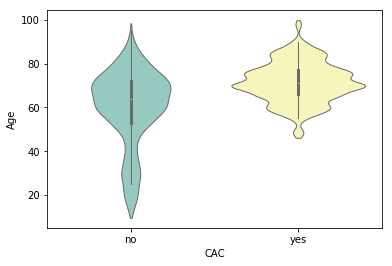

In [127]:
sns.violinplot(x='CAC', y='Age', data=cleaned, palette="Set3", bw=.2, cut=1, linewidth=1)

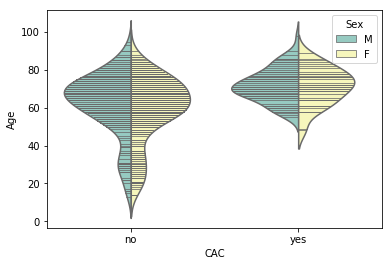

In [128]:
sns.violinplot(x="CAC", y="Age", hue="Sex", data=cleaned_noUndefinedSex,
               split=True, inner="stick", palette="Set3");

[Text(0,0.5,'Sex Percentage')]

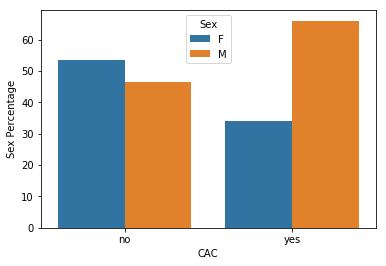

In [199]:
a = cleaned[['CAC', 'Sex', 'count']].groupby(['CAC', 'Sex']).count()
sexcac=a.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()), 2)).reset_index()
ax = sns.barplot(x="CAC", y="count", hue="Sex", data=sexcac)
#ax = sns.countplot(x="CAC", hue="Sex", data=cleaned)
ax.set(ylabel="Sex Percentage")

[Text(0,0.5,'Hx of HTN (%)')]

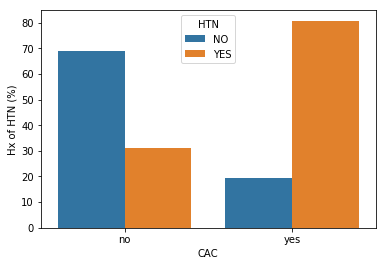

In [201]:
a = cleaned[['CAC', 'HTN', 'count']].groupby(['CAC', 'HTN']).count()
sexcac=a.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()), 2)).reset_index()
ax = sns.barplot(x="CAC", y="count", hue="HTN", data=sexcac)
ax.set(ylabel="Hx of HTN (%)")

In [142]:
res=pearsonr(cleaned_noUndefinedSex['cacv'], cleaned_noUndefinedSex['sexv'])
print('correlation: {}, p-value:{}'.format(res[0], res[1]))

correlation: -0.15099522594785442, p-value:0.00018854781358085523


In [139]:
res=pearsonr(cleaned['cacv'], cleaned['htnv'])#.corr(method='pearson')
print('correlation: {}, p-value:{}'.format(res[0], res[1]))

correlation: 0.3908175068904315, p-value:1.2705623267616409e-23


In [140]:
res=pearsonr(cleaned['cacv'], cleaned['Age'])#.corr(method='pearson')
print('correlation: {}, p-value:{}'.format(res[0], res[1]))

correlation: 0.2611176149858496, p-value:6.18991736947498e-11


In [205]:
logreg=linear_model.LogisticRegression(class_weight="balanced")
y = cleaned_noUndefinedSex['CAC']
predicted = cross_validation.cross_val_predict(logreg, 
                                               cleaned_noUndefinedSex[['htnv', 'sexv', 'Age']], 
                                               y , cv=10)
print(metrics.accuracy_score(y, predicted))
print(metrics.classification_report(y, predicted))

0.710049423394
             precision    recall  f1-score   support

         no       0.94      0.69      0.80       498
        yes       0.36      0.81      0.50       109

avg / total       0.84      0.71      0.74       607



In [204]:
classifier=svm.SVC(kernel='rbf', class_weight="balanced")
y = cleaned_noUndefinedSex['CAC']
predicted = cross_validation.cross_val_predict(classifier, 
                                               cleaned_noUndefinedSex[['htnv', 'sexv', 'Age']], 
                                               y , cv=10)
print(metrics.accuracy_score(y, predicted))
print(metrics.classification_report(y, predicted))

0.701812191104
             precision    recall  f1-score   support

         no       0.90      0.71      0.80       498
        yes       0.33      0.65      0.44       109

avg / total       0.80      0.70      0.73       607

